In [501]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# define ilr and inverse ilr

In [502]:
def get_n_plus_and_n_minus(theta, w):
    Dm1, D = theta.shape
    n_plus = np.empty(Dm1, dtype=np.float)
    n_minus = np.empty(Dm1, dtype=np.float)
    for i in range(Dm1):
        n_plus[i] = np.sum(w[theta[i]==1])
        n_minus[i] = np.sum(w[theta[i]==-1])
    return n_plus, n_minus

In [503]:
def get_psi(theta, n_plus, n_minus):
    m, n = theta.shape
    psi = np.zeros_like(theta, dtype=np.float)
    for i in range(m):
        for j in range(n):
            if theta[i, j] == 1:
                psi[i, j] = 1/n_plus[i] * np.sqrt(n_plus[i] * n_minus[i] / (n_plus[i] + n_minus[i]))
            elif theta[i, j] == -1:
                psi[i, j] = -1/n_minus[i] * np.sqrt(n_plus[i] * n_minus[i] / (n_plus[i] + n_minus[i]))
    return psi

In [504]:
def log_geometric_mean(y, w):
    return np.sum(w * np.log(y), axis=-1)/np.sum(w, axis=-1)

In [505]:
def ilr_transform(x, w, theta, n_plus, n_minus):
    """
    x: (D, ), w: (D, ), theta: (D-1, D), n_plus: (D-1, ), n_minuse: (D-1, )
    return ystar: (D-1, )
    """
    D, = x.shape
    y = x / w

    # compute log geometric mean ratio
    log_gm_ratio = np.empty((D-1,), dtype=np.float)
    for i in range(D-1):
        plus_idx = theta[i] == 1
        loggp_yi_plus = log_geometric_mean(y[plus_idx], w[plus_idx])
            
        minus_idx = theta[i] == -1
        loggp_yi_minus = log_geometric_mean(y[minus_idx], w[minus_idx])
         
        log_gm_ratio[i] = loggp_yi_plus - loggp_yi_minus
    
    normalizing_constant = np.sqrt(n_plus * n_minus / (n_plus + n_minus))  # (D-1, )
    
    ystar = normalizing_constant * log_gm_ratio
    return ystar

In [506]:
def inverse_ilr_transform(ystar, psi, w):
    """
    ystar: (D-1,), psi: (D-1, D), w: (D, )
    return: x: (D,)
    """
    
    # (1, D-1) * (D-1, D) -> (1, D)
    exp_ystar_psi = np.exp(np.matmul(ystar[None,], psi))
    exp_ystar_psi = exp_ystar_psi.squeeze(0)
    
    y = exp_ystar_psi / np.sum(exp_ystar_psi)
    x = y * w / np.sum(y * w)
    return x

## test inverse transformation

In [507]:
def test_inv_ilr_transform():
    # tree structrue
    theta = np.array([[+1,-1,-1,0,0,0], 
                     [0,+1,-1,0,0,0],
                     [+1,+1,+1,-1,-1,-1,],
                     [0,0,0,+1,-1,0],
                     [0,0,0,+1,+1,-1]])
    # counts
    c = np.array([10, 20, 30, 40, 25, 15], dtype=np.float)
    x = c / c.sum()
    # weights
    w = np.array([2.1, 3.2, 3, 5, 10, 2])
    
    # ilr transformation
    n_plus, n_minus = get_n_plus_and_n_minus(theta, w)
    psi = get_psi(theta, n_plus, n_minus)
    ystar = ilr_transform(x, w, theta, n_plus, n_minus)
    
    x_recon = inverse_ilr_transform(ystar, psi, w)
    
    assert ((x_recon - x) < 1e-12).all()
    print("x_recon = ", x_recon)
    print("x = ", x)
    print("past test!")
    
test_inv_ilr_transform()

x_recon =  [0.07142857 0.14285714 0.21428571 0.28571429 0.17857143 0.10714286]
x =  [0.07142857 0.14285714 0.21428571 0.28571429 0.17857143 0.10714286]
past test!


# dynamics

For any **inner** node $i$, $y_i^*$ will change either according between-group interaction or in-group interaction.
1. For between-group interaction,
   * The probability that $y_i^*$ will change according to between-group interaction is: $p(i \text{ break}) = \left[\prod_{a \in a_i} b_a \right] \cdot b_i$, where $a_i$ are node $i$'s ancestors.
   * Conditioning on that $y_i^*$ will change according to between-group interaction, then $a_i$ are bound to break. The remaing consideration is, for any node $j (j \neq i)$ that is not in $a_i$, the probability that node $j$ represents a group, i.e., j doesn't break but node $j$'s ancestors break:
   $$p(j \text{ represent group}| i \text{ break}) = \prod_{k \in a_j \cap \neg (a_i \cup \{i\})} b_k \cdot (1 - b_j),$$ where $\neg U$ represents nodes are not in set $U$.
   * Note, if $a_j \cap \neg (a_i \cup \{i\})=\emptyset$, there are three cases:

    * $i$ is the parent of $j$, then $p(j \text{ represent group}| i \text{ break}) = 1-b_j$

    * $i$ and $j$ has the same parent, then $p(j \text{ represent group}| i \text{ break}) = 1-b_j$.

    * $j$ is the parent of $i$, then $p(j \text{ represent group}| i \text{ break}) = 0$.

   * Then $y_i^*$'s between-group interaction change rate will be 
   $$\frac{dy_i^*}{dt} = p(i \text{ break}) \cdot (g_i + \sum_{j\in \neg (a_i \cup \{i\})} p(j \text{ represent group}| i \text{ break}) \cdot A_{ij} \cdot r_j),$$ where $r_j$ is the relative abundance of node $j$.

2. For in-group interaction,
   * If inode $i$ will change according to in-group interaction, notice that it could only be affected by taxon node and other inodes will have no effect on $i$.
   * The remaining thing is to determine the probability that each taxon node $j$ will affect $i$, which is the probability that taxon node $j$ and inode $i$ are in the same group. To be in the same group, their common ancestor must not break, and the probability is
   $$p(j \text{ in same group as } i| i \text{ not break}) = 1 - \prod_{k \in a_j \cap (a_i \cup \{i\})} b_k $$
   * Meanwhile, for growth rate, we only need to consider the probability that inode $i$ will not break: $p(i \text{ not break}) = 1 - p(i \text{ break}) = 1 - \left[\prod_{a \in a_i} b_a \right] \cdot b_i$
   * Then $y_i^*$'s between-group interaction change rate will be 
   $$\frac{dy_i^*}{dt} = p(i \text{ not break}) \cdot g_i + \sum_{j\in \text{taxa}} p(j \text{ in same group as } i| i \text{ not break}) \cdot A_{ij} \cdot r_j,$$ where $r_j$ is the relative abundance of node $j$.

### tree data structure setup

In [508]:
class Tree(object):
    def __init__(self, parent=None, left=None, right=None, node_idx=None, inode_idx=None, taxon_idx=None, b=0.5):
        self.left = left
        self.right = right
        self.parent = parent
        self.b = b  # break score
        self.inode_idx = inode_idx  #internal node (not taxon)
        self.taxon_idx = taxon_idx 
        self.node_idx = node_idx 
        #if node is internal node, node_idx=inode_idx; elif node is taxon, node_idx = num_inodes + taxon_idx
    
    def __repr__(self):
        return "tree at " + self.name()
        
    def is_taxon(self):
        return self.left is None and self.right is None
    
    def print_tree(self, level=0):
        name = self.name()
        print("   " * level + name)
        if self.left is not None:
            self.left.print_tree(level+1)
        if self.right is not None:
            self.right.print_tree(level+1)

    def name(self):
        if self.is_taxon():
            name = "node {} taxon {}".format(self.node_idx, self.taxon_idx)
        else:
            name = "node {} inode {}".format(self.node_idx, self.inode_idx)
        return name

In [509]:
def convert_theta_to_tree(theta):
    n_node = theta.shape[0] + theta.shape[1]
    node_reference = [0] * n_node  # placeholder
    root = convert_theta_to_tree_helper(theta, node_reference, None)
    return root, node_reference

def convert_theta_to_tree_helper(theta, node_reference, parent, is_left_child=True):
    # find and return parent's left/right child node
    if parent is None:
        n_taxa = theta.shape[1]
        node_taxa = np.arange(n_taxa)
    else:
        parent_taxon_idx = parent.inode_idx
        assert parent_taxon_idx is not None
        theta_node = theta[parent_taxon_idx]
        if is_left_child:
            node_taxa = np.where(theta_node == +1)[0]
        else:
            node_taxa = np.where(theta_node == -1)[0]
    
    if len(node_taxa) == 1:
        taxon_idx = node_taxa[0]
        n_inode = theta.shape[0]  # number of internal nodes
        node_idx = n_inode + taxon_idx
        child = Tree(parent=parent, taxon_idx=taxon_idx, node_idx=node_idx, b=0)  # taxon nodes cannot break
        node_reference[node_idx] = child
    else:
        inode_idx = -1
        for i, theta_i in enumerate(theta):
            leaves = np.where(theta_i != 0)[0]
            if len(leaves) == len(node_taxa) and (leaves == node_taxa).all():
                inode_idx = i
                break
        
        child = Tree(parent=parent, inode_idx=inode_idx, node_idx=inode_idx)
        child.left = convert_theta_to_tree_helper(theta, node_reference, child, is_left_child=True)
        child.right = convert_theta_to_tree_helper(theta, node_reference, child, is_left_child=False)
        node_reference[inode_idx] = child

    return child

In [510]:
def get_p_i(n_inode, root):
    p_i = np.empty(n_inode)
    get_p_i_helper(p_i, root, 1)
    return p_i

def get_p_i_helper(p_i, node, p_ancestors_break):
    if node.is_taxon():
        return
    node_idx = node.node_idx
    p_ancestors_break *= node.b
    p_i[node_idx] = p_ancestors_break
    get_p_i_helper(p_i, node.left, p_ancestors_break)
    get_p_i_helper(p_i, node.right, p_ancestors_break)

In [511]:
def get_between_group_p_j_given_i(n_node, n_inode, root):
    p_j_given_i = np.empty((n_inode, n_node))
    get_between_group_p_j_given_i_helper(p_j_given_i, n_node, root, root)
    return p_j_given_i

def get_between_group_p_j_given_i_helper(p_j_given_i, n_node, root, node):
    # node: inode i
    if node.is_taxon():
        return
    b_copy = node.b
    node.b = 1
    p_j_given_inode = np.empty(n_node)
    # iterate over j=0:n_node-1
    get_between_group_p_j_given_inode_helper(p_j_given_inode, root, 1)
    get_between_group_p_j_given_i_helper(p_j_given_i, n_node, root, node.left)
    get_between_group_p_j_given_i_helper(p_j_given_i, n_node, root, node.right)

    inode_idx = node.inode_idx
    p_j_given_i[inode_idx] = p_j_given_inode
    node.b = b_copy
    
def get_between_group_p_j_given_inode_helper(p_j_given_inode, node, p_ancestors_break):
    if node is None:
        return
    node_idx = node.node_idx
    p_j_given_inode[node_idx] = p_ancestors_break * (1 - node.b)
    get_between_group_p_j_given_inode_helper(p_j_given_inode, node.left, p_ancestors_break * node.b)
    get_between_group_p_j_given_inode_helper(p_j_given_inode, node.right, p_ancestors_break * node.b)

In [512]:
def get_in_group_p_j_given_i(n_node, n_inode, root):
    p_j_given_i = np.empty((n_inode, n_node))
    get_in_group_p_j_given_i_initialization(root)
    get_in_group_p_j_given_i_helper(p_j_given_i, n_node, root, root)
    get_in_group_p_j_given_i_clean(root)
    return p_j_given_i

def get_in_group_p_j_given_i_initialization(root):
    def helper(node):
        node.is_ancestor_of_i = False
        if not node.is_taxon():
            helper(node.left)
            helper(node.right)
    helper(root)

def get_in_group_p_j_given_i_clean(root):
    def helper(node):
        del node.is_ancestor_of_i
        if not node.is_taxon():
            helper(node.left)
            helper(node.right)
    helper(root)

def get_in_group_p_j_given_i_helper(p_j_given_i, n_node, root, node):
    # node: inode i
    if node.is_taxon():
        return

    node.is_ancestor_of_i = True  # tmp value
    p_j_given_inode = np.empty(n_node)
    get_in_group_p_j_given_inode_helper(p_j_given_inode, root, 1)
    inode_idx = node.inode_idx
    p_j_given_i[inode_idx] = p_j_given_inode

    get_in_group_p_j_given_i_helper(p_j_given_i, n_node, root, node.left)
    get_in_group_p_j_given_i_helper(p_j_given_i, n_node, root, node.right)

    node.is_ancestor_of_i = False

def get_in_group_p_j_given_inode_helper(p_j_given_inode, node, p_common_ancestors_break):
    node_idx = node.node_idx
    if node.is_taxon():
        p_j_given_inode[node_idx] = 1 - p_common_ancestors_break
    else:
        p_j_given_inode[node_idx] = 0.0
        if node.is_ancestor_of_i:
            p_common_ancestors_break *= node.b
        get_in_group_p_j_given_inode_helper(p_j_given_inode, node.left, p_common_ancestors_break)
        get_in_group_p_j_given_inode_helper(p_j_given_inode, node.right, p_common_ancestors_break)

In [513]:
def set_b(reference, bs):
    for i, b in enumerate(bs):
        reference[i].b = b

In [514]:
def test_dynamics():
    theta3 = np.array([[+1, -1,  0,  0,  0,  0,  0,  0], 
                       [+1, +1, -1, -1, -1,  0,  0,  0],
                       [ 0,  0, +1, -1, -1,  0,  0,  0],
                       [ 0,  0,  0, +1, -1,  0,  0,  0], 
                       [+1, +1, +1, +1, +1, -1, -1, -1],
                       [ 0,  0,  0,  0,  0, +1, -1, -1], 
                       [ 0,  0,  0,  0,  0,  0, +1, -1]])
    # get tree
    root3, reference3 = convert_theta_to_tree(theta3)
    
    b3 = np.array([0., 1., 1., 0., 1., 1., 0.])
    set_b(reference3, b3)

    p_i_3_true = np.array([0, 1, 1, 0, 1, 1, 0])
    between_p_j_given_i_3_true = np.array([[0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0], 
                                           [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
                                           [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
                                           [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
                                           [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
                                           [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
                                           [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]])
    in_p_j_given_i_3_true = np.array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], 
                                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
                                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

    p_i_3 = get_p_i(theta3.shape[0], root3)
    between_p_j_given_i_3 = get_between_group_p_j_given_i(theta3.shape[0] + theta3.shape[1], theta3.shape[0], root3)
    in_p_j_given_i_3 = get_in_group_p_j_given_i(theta3.shape[0] + theta3.shape[1], theta3.shape[0], root3)
    assert (p_i_3 == p_i_3_true).all()
    assert (between_p_j_given_i_3 == between_p_j_given_i_3_true).all()
    assert (in_p_j_given_i_3 == in_p_j_given_i_3_true).all()
    print("pass test!")

test_dynamics()

pass test!


In [515]:
def test_soft_bs():
    soft_bs = np.array([0.8, 0.2, 0.9, 0.1, 0.1])
    hard_bs = np.array([1, 0, 1, 0, 0])
    
    # tree structue
    theta = np.array([[+1, -1, -1,  0,  0,  0], 
                      [ 0, +1, -1,  0,  0,  0],
                      [+1, +1, +1, -1, -1, -1],
                      [ 0,  0,  0, +1, -1,  0],
                      [ 0,  0,  0, +1, +1, -1]])

    # get tree
    root, reference = convert_theta_to_tree(theta)
    n_inode = theta.shape[0]
    n_node = theta.shape[0] + theta.shape[1]
    
    # use soft bs
    set_b(reference, soft_bs)
    p_i = get_p_i(n_inode, root)
    between_p_j_given_i = get_between_group_p_j_given_i(n_node, n_inode, root)
    between_mask_for_soft_A = p_i[:, None] * between_p_j_given_i
    in_p_j_given_i = get_in_group_p_j_given_i(n_node, n_inode, root)
    in_mask_for_soft_A = in_p_j_given_i
    
    # use hard bs
    set_b(reference, hard_bs)
    p_i = get_p_i(n_inode, root)
    between_p_j_given_i = get_between_group_p_j_given_i(n_node, n_inode, root)
    between_mask_for_hard_A = p_i[:, None] * between_p_j_given_i
    in_p_j_given_i = get_in_group_p_j_given_i(n_node, n_inode, root)
    in_mask_for_hard_A = in_p_j_given_i
    # print("between_mask_for_soft_A = ")
    # print("\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in between_mask_for_soft_A]))
    # print("between_mask_for_hard_A = ")
    # print("\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in between_mask_for_hard_A]))
    # print("in_mask_for_soft_A = ")
    # print("\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in in_mask_for_soft_A]))
    # print("in_mask_for_hard_A = ")
    # print("\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in in_mask_for_hard_A]))
    assert (np.round(between_mask_for_soft_A) == between_mask_for_hard_A).all()
    assert (np.round(in_mask_for_soft_A) == in_mask_for_hard_A).all()
    print("pass test!")

test_soft_bs()

pass test!


In [516]:
def get_inode_relative_abundance(root, x_t, n_inode):
    r_t_inode = np.empty(n_inode)
    get_inode_relative_abundance_helper(r_t_inode, root, x_t)
    return r_t_inode
    
def get_inode_relative_abundance_helper(r_t_inode, node, x_t):
    if node.is_taxon():
        return x_t[node.taxon_idx]
    inode_idx = node.inode_idx
    left_r_t = get_inode_relative_abundance_helper(r_t_inode, node.left, x_t)
    right_r_t = get_inode_relative_abundance_helper(r_t_inode, node.right, x_t)
    inode_r_t = left_r_t + right_r_t
    r_t_inode[inode_idx] = inode_r_t
    return inode_r_t    

def simulate(root, psi, g_in, A_in, g_between, A_between, N, n_days, init_y_star, transition_sigma=0.0):
    def transition_step(ystar_t):
        """
        ystar_t: (D-1, )
        return ystar_tp1: (D-1,)
        """
        # (1, D-1) * (D-1, D) -> (1, D)
        Dm1, = ystar_t.shape
        x_t = inverse_ilr_transform(ystar_t, psi, w)
        r_t_inode = get_inode_relative_abundance(root, x_t, len(ystar_t))
        r_t = np.concatenate([r_t_inode, x_t])
        ystar_tp1 = ystar_t + g_in + g_between + (A_in + A_between).dot(r_t) + transition_sigma * np.random.randn(Dm1)
       
        return ystar_tp1

    def emission_step(ystar_t):
        """
        ystar_t: (D-1, )
        return c_t: (D)
        """
        x_t = inverse_ilr_transform(ystar_t, psi, w)
        logN = np.random.normal(loc=np.log(N), scale=0.5)
        N_t = np.random.poisson(np.exp(logN))
        c_t= np.random.multinomial(N_t, x_t).astype(float)
        return x_t, c_t

    n_inode, n_node = A_in.shape
    n_taxa = n_node - n_inode
    
    #y_star = np.random.randn(n_inode) * init_variance
    y_star = init_y_star

    Y = []
    X = []
    C = []
    for _ in range(n_days):
        x, c = emission_step(y_star)
        Y.append(y_star)
        X.append(x)
        C.append(c)
        y_star = transition_step(y_star)
        
    return np.array(Y), np.array(X), np.array(C)

# Simulate data

In [517]:
# tree structure
theta = np.array([[+1, -1, -1,  0,  0,  0], 
                  [ 0, +1, -1,  0,  0,  0],
                  [+1, +1, +1, -1, -1, -1],
                  [ 0,  0,  0, +1, -1,  0],
                  [ 0,  0,  0, +1, +1, -1]])

bs = np.array([1, 0, 1, 0, 0])

In [518]:
theta = np.array([[+1, -1,  0,  0,  0,  0,  0,  0], 
                  [+1, +1, -1, -1, -1,  0,  0,  0],
                  [ 0,  0, +1, -1, -1,  0,  0,  0],
                  [ 0,  0,  0, +1, -1,  0,  0,  0], 
                  [+1, +1, +1, +1, +1, -1, -1, -1],
                  [ 0,  0,  0 , 0,  0, +1, -1, -1], 
                  [ 0,  0,  0,  0,  0,  0, +1, -1]])

bs = np.array([0., 1, 0, 1, 1, 1, 0])

In [519]:
granularity = 1
theta = np.array([[+1, +1, +1, +1, +1, +1, +1, +1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [+1, +1, +1, +1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0, +1, +1, +1, +1, -1, -1, -1, -1],
                  [+1, +1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0 , 0, +1, +1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1],
                  [+1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1]])
bs = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
n_breaks = 2 ** granularity - 1
bs[:n_breaks] = np.ones(n_breaks)
print(bs)

g_in = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
A_in = np.array([[+1, +1, +1, +1, +1, +1, +1, +1, -1, -1, -1, -1, -1, -1, -1, -1],
                 [-1, -1, -1, -1, +1, +1, +1, +1,  0,  0,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, +1, +1, +1, +1],
                 [-1, -1, +1, +1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0,  0, -1, -1, +1, +1,  0,  0,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0, -1, -1, +1, +1,  0,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, +1, +1],
                 [-1, +1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [ 0,  0, -1, +1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0,  0, -1, +1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0, -1, +1,  0,  0,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0, -1, +1,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, +1,  0,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, +1,  0,  0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, +1]])
A_in = np.concatenate([np.zeros((15, 15)), A_in], axis=-1)
g_between = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
A_between = np.array([[ 0, -1, +1, -1, -1, +1, +1, -1, -1, -1, -1, +1, +1, +1, +1],
                      [ 0,  0,  0, -1, +1,  0,  0, -1, -1, +1, +1,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0, -1, +1,  0,  0,  0,  0, -1, -1, +1, +1],
                      [ 0,  0,  0,  0,  0,  0,  0, -1, +1,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1, +1,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, +1,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, +1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
A_between = np.concatenate([A_between, np.zeros((15, 16))], axis=-1)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [520]:
balance = 1
theta = np.array([[+1, +1, +1, +1, +1, +1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [+1, +1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0, +1, +1, +1, +1, -1, -1, -1, -1, -1, -1],
                  [+1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0, +1, +1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0, +1, +1, -1, -1,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1, -1, -1],
                  [ 0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1]])
bs = np.array([1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0])

g_in = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
A_in = -theta
A_in = np.concatenate([np.zeros((15, 15)), A_in], axis=-1)
g_between = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
A_between = np.array([[ 0,  0,  0, +1,  0,  0,  0, +1, +1, -1, -1, -1,  0, -1, -1],
                      [ 0,  0,  0, +1,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
A_between = -A_between
A_between = np.concatenate([A_between, np.zeros((15, 16))], axis=-1)

In [521]:
balance = 2
theta = np.array([[+1, +1, +1, +1, +1, +1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [+1, +1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0, +1, +1, +1, +1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [+1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0, +1, +1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0, +1, +1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1, -1, -1, -1, -1],
                  [ 0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1]])
bs = np.array([1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

g_in = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
A_in = -theta
A_in = np.concatenate([np.zeros((17, 17)), A_in], axis=-1)
g_between = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
A_between = np.array([[ 0,  0,  0, +1,  0,  0,  0, +1, +1, -1, -1, -1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0, +1,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
A_between = -A_between
A_between = np.concatenate([A_between, np.zeros((17, 18))], axis=-1)

In [522]:
balance = 3
theta = np.array([[+1, +1, +1, +1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [+1, +1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0, +1, +1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [+1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0, +1, +1, -1, -1, -1, -1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1]])
bs = np.array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0])

g_in = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
A_in = -theta
A_in = np.concatenate([np.zeros((13, 13)), A_in], axis=-1)
g_between = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
A_between = np.array([[ 0,  0,  0, +1, +1, -1,  0, -1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0, +1,  0, -1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0, +1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0, +1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
A_between = -A_between
A_between = np.concatenate([A_between, np.zeros((13, 14))], axis=-1)

In [523]:
balance = 4
theta = np.array([[+1, +1, +1, +1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [+1, +1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0, +1, +1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [+1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0, +1, +1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1, -1, -1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1]])
bs = np.array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0])

g_in = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
A_in = -theta
A_in = np.concatenate([np.zeros((15, 15)), A_in], axis=-1)
g_between = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
A_between = np.array([[ 0,  0,  0, +1, +1, -1,  0, -1,  0, -1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0, +1,  0, -1,  0, -1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0, +1,  0, -1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0, +1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
A_between = -A_between
A_between = np.concatenate([A_between, np.zeros((15, 16))], axis=-1)

In [524]:
balance = 6
theta = np.array([[+1, +1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [+1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0, +1, +1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [ 0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0, +1, +1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [ 0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0, +1, +1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1, -1, -1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1]])
bs = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0])

g_in = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
A_in = -theta
A_in = np.concatenate([np.zeros((15, 15)), A_in], axis=-1)
g_between = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
A_between = np.array([[ 0, +1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0, +1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0, +1,  0, -1,  0, -1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0, +1,  0, -1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0, +1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
A_between = -A_between
A_between = np.concatenate([A_between, np.zeros((15, 16))], axis=-1)

In [525]:
balance = 5
theta = np.array([[+1, +1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [+1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0, +1, +1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [ 0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0, +1, +1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [ 0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0, +1, +1, -1, -1, -1, -1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, +1, -1, -1],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1]])
bs = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0])

g_in = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
A_in = -theta
A_in = np.concatenate([np.zeros((13, 13)), A_in], axis=-1)
g_between = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
A_between = np.array([[ 0, +1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0, +1,  0, -1,  0, -1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0, +1,  0, -1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0, +1,  0, -1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0, +1,  0, -1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, +1, -1],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
A_between = -A_between
A_between = np.concatenate([A_between, np.zeros((13, 14))], axis=-1)

In [526]:
n_taxon = theta.shape[1]
w = np.ones(n_taxon)

# ilr transformation
n_plus, n_minus = get_n_plus_and_n_minus(theta, w)
psi = get_psi(theta, n_plus, n_minus)

# get tree
root, reference = convert_theta_to_tree(theta)
root.print_tree()

# set break scores
set_b(reference, bs)

node 0 inode 0
   node 1 inode 1
      node 13 taxon 0
      node 14 taxon 1
   node 2 inode 2
      node 3 inode 3
         node 15 taxon 2
         node 16 taxon 3
      node 4 inode 4
         node 5 inode 5
            node 17 taxon 4
            node 18 taxon 5
         node 6 inode 6
            node 7 inode 7
               node 19 taxon 6
               node 20 taxon 7
            node 8 inode 8
               node 9 inode 9
                  node 21 taxon 8
                  node 22 taxon 9
               node 10 inode 10
                  node 11 inode 11
                     node 23 taxon 10
                     node 24 taxon 11
                  node 12 inode 12
                     node 25 taxon 12
                     node 26 taxon 13


In [527]:
# calcualte probs
n_inode = theta.shape[0]
n_node = theta.shape[0] + theta.shape[1]
between_group_p_i = get_p_i(n_inode, root)
between_group_p_j_given_i = get_between_group_p_j_given_i(n_node, n_inode, root)
in_group_p_i = 1.0 - between_group_p_i
in_group_p_j_given_i = get_in_group_p_j_given_i(n_node, n_inode, root)

In [528]:
n_taxa = theta.shape[1]

In [529]:
# set dynamics parameters
exist_in_group_dynamics = True

np.random.seed(0)
# g_in = np.round(np.random.uniform(-5, 5, n_inode)) * 0.002
# A_in = np.round(np.random.uniform(-6, 6, (n_inode, n_node))) * 0.1
# g_between = np.round(np.random.uniform(-5, 5, n_inode)) * 0.002
# A_between = np.round(np.random.uniform(-6, 6, (n_inode, n_node))) * 0.1
A_in_scale = 0.1
A_in = np.array(A_in, dtype=np.float64) * A_in_scale
A_between = np.array(A_between, dtype=np.float64) * 0.5
if not exist_in_group_dynamics:
    g_in *= 0.0
    A_in *= 0.0
masked_g_in = in_group_p_i * g_in
masked_A_in = in_group_p_j_given_i * A_in
masked_g_between = between_group_p_i * g_between
masked_A_between = between_group_p_i[:, None] * between_group_p_j_given_i * A_between

print("masked_g_in")
print(" ".join(["{:>5.2f}".format(ele) for ele in masked_g_in]))
print("masked_A_in")
print("\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in masked_A_in]))

print("masked_g_between")
print(" ".join(["{:>5.2f}".format(ele) for ele in masked_g_between]))
print("masked_A_between")
print("\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in masked_A_between]))

masked_g_in
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
masked_A_in
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.00 -0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.10  0.10  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.00 -0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.10  0.10  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.00 -0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0

In [530]:
N = 10000
n_train, n_test = 300, 10

n_days = 30
days = np.arange(n_days)[:,None]

In [531]:
x_train = []
y_train = []
input_train = []

init_variance = 2
transition_sigma = 0.25

for i in range(n_train):
    # init y_star
    x = np.random.randn(n_taxa) * init_variance
    x = np.exp(x) / np.sum(np.exp(x))
    init_y_star = ilr_transform(x, w, theta, n_plus, n_minus)
    
    Y, X, C = simulate(root, psi, masked_g_in, masked_A_in, masked_g_between, masked_A_between, N, n_days, init_y_star, transition_sigma)
    C_with_date_stamp = np.concatenate([days, C], axis=-1)
    x_train.append(Y)
    y_train.append(C_with_date_stamp)
    input_train.append(days)
    
x_test = []
y_test = []
input_test = []
for i in range(n_test):
    # init y_star
    x = np.random.randn(n_taxa) * init_variance
    x = np.exp(x) / np.sum(np.exp(x))
    init_y_star = ilr_transform(x, w, theta, n_plus, n_minus)
    
    Y, X, C = simulate(root, psi, masked_g_in, masked_A_in, masked_g_between, masked_A_between, N, n_days, init_y_star, transition_sigma)
    C_with_date_stamp = np.concatenate([days, C], axis=-1)
    x_test.append(Y)
    y_test.append(C_with_date_stamp)
    input_test.append(days)

# save

In [532]:
import pickle

In [533]:
c_data = {}

c_data['theta'] = theta
c_data["b"] = bs

c_data['Ytrain'] = y_train  # count
c_data['Ytest'] = y_test
c_data['Xtrain'] = x_train # ystar
c_data['Xtest'] = x_test

c_data['Vtrain'] = input_train
c_data['Vtest'] = input_test

c_data["A_in"] = A_in
c_data["g_in"] = g_in
c_data["masked_A_in"] = masked_A_in
c_data["masked_g_in"] = masked_g_in

c_data["A_between"] = A_between
c_data["g_between"] = g_between
c_data["masked_A_between"] = masked_A_between
c_data["masked_g_between"] = masked_g_between

A_in_scale = int(A_in_scale / 0.5 * 100)
with open("vary_balance/{}_taxa_balance_{}_mag_{:02d}.p".format(n_taxon, balance, A_in_scale), "wb") as f:
    pickle.dump(c_data, f)

# visualize data

In [534]:
import sys
sys.path.append("../..")
from src.utils.data_interpolation import interpolate_data

In [535]:
obs_train, obs_test = [], []
for y in y_train:
    days, counts = y[:, :1], y[:, 1:]
    perc = counts / counts.sum(axis=-1, keepdims=True)
    obs_train.append(np.concatenate([days, perc], axis=-1))
for y in y_test:
    days, counts = y[:, :1], y[:, 1:]
    perc = counts / counts.sum(axis=-1, keepdims=True)
    obs_test.append(np.concatenate([days, perc], axis=-1))
extra_inputs_train = [None for _ in range(len(obs_train))]
extra_inputs_test = [None for _ in range(len(obs_test))]

In [536]:
def bar_plot(ax, obs, mask, to_normalize=True):
    if to_normalize:
        obs = obs / np.sum(obs, axis=-1, keepdims=True)

    time, Dy = obs.shape

    # make missing obs = 0
    masked_obs = np.zeros_like(obs)
    masked_obs[mask] = obs[mask]
    
    ax.set_xlabel("Time")
    bottom = np.zeros(time)
    for j in range(Dy):
        ax.bar(np.arange(time), masked_obs[:, j], bottom=bottom, edgecolor='white')
        bottom += masked_obs[:, j]

    ax.set_xticks(np.arange(time))
    sns.despine()
    

def input_plot(ax, inputs):
    time, Dv = inputs.shape
    
    for j in range(Dv):
        has_inputs = inputs[:,j]== 1
        idx = np.arange(time)[has_inputs]
        ax.bar(idx, [1 for _ in idx], bottom=[j for _ in idx], color='blue')
    
    ax.set_xticks(np.arange(time))
    ax.set_yticks(np.arange(Dv))
    sns.despine()

In [537]:
def plot_inputs_and_obs(inputs, obs, masks, i, to_normalize=True):
    if inputs[0].shape[1] == 0:
        plt.figure(figsize=(15,5))

        ax2 = plt.gca()
        bar_plot(ax2, obs[i], masks[i], to_normalize=to_normalize)
        ax2.grid()
    else:
        plt.figure(figsize=(15,10))

        ax1= plt.subplot(2,1,1)
        input_plot(ax1, inputs[i])
        ax1.grid()

        ax2 = plt.subplot(2,1,2, sharex = ax1)
        bar_plot(ax2, obs[i], masks[i], to_normalize=to_normalize)
        ax2.grid()

In [538]:
hidden_train, hidden_test = x_train, x_test

In [539]:
hidden_train, hidden_test, obs_train, obs_test, input_train, input_test, _mask_train, _mask_test, time_interval_train, time_interval_test, extra_inputs_train, extra_input_test = \
    interpolate_data(hidden_train, hidden_test, obs_train, obs_test, input_train, input_test,
                     extra_inputs_train, extra_inputs_test, interpolation_type=None)

masks = _mask_train + _mask_test
obs = obs_train + obs_test
inputs = input_train + input_test

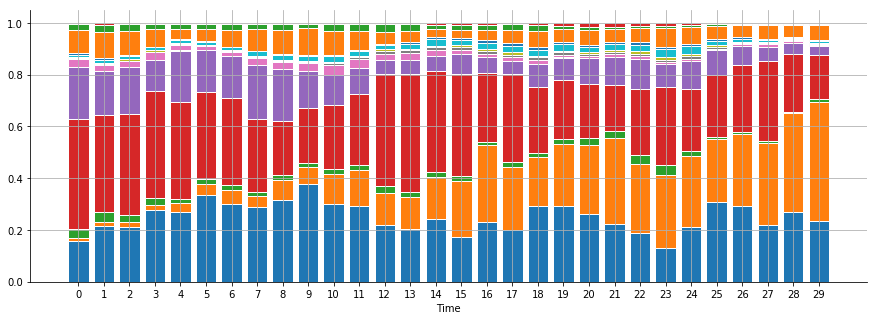

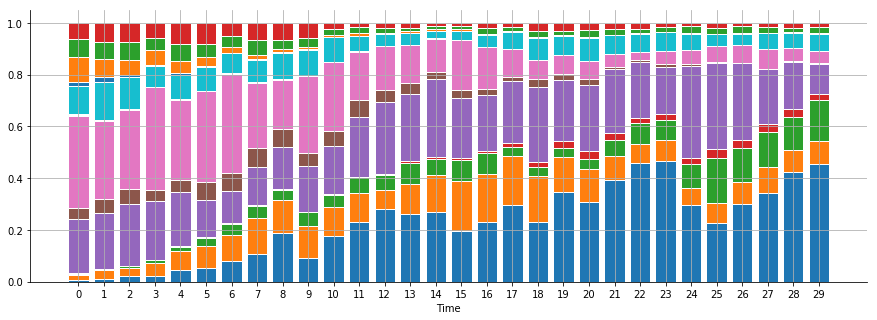

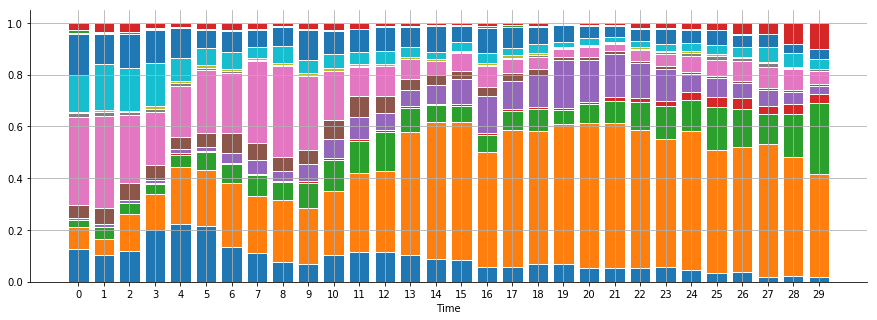

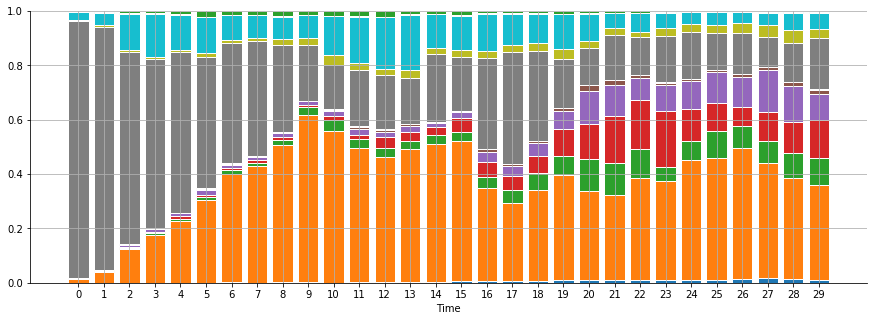

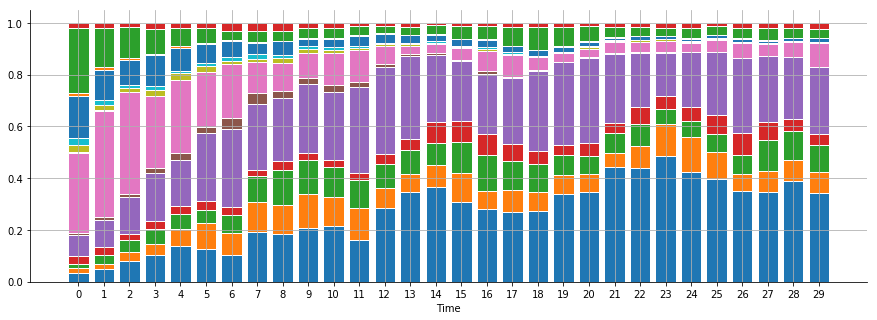

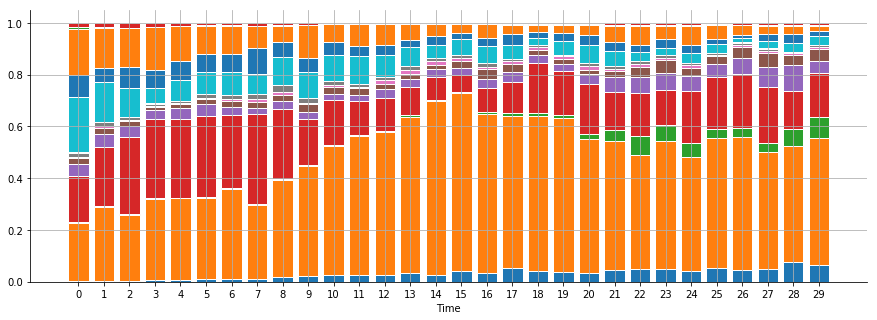

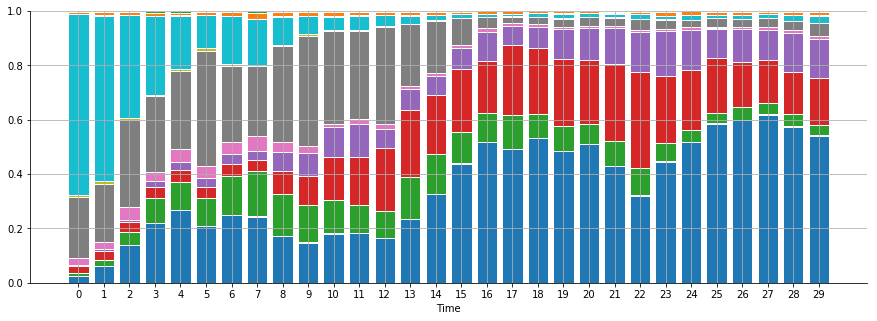

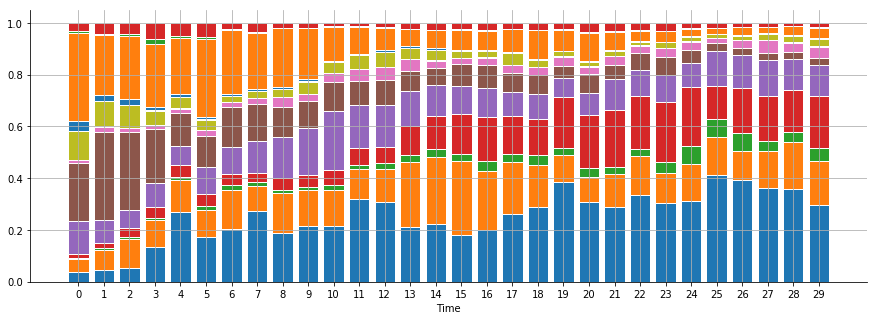

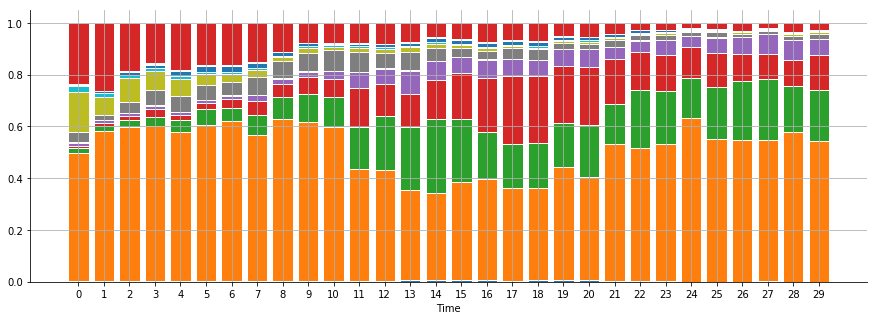

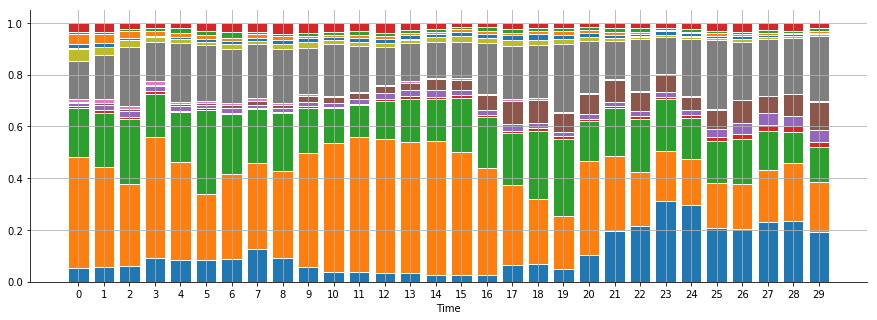

In [540]:
for i in range(0, 10):
    plot_inputs_and_obs(inputs, obs, masks, i)